## Geo Data Analysis Using PyTorch

In [ ]:
import torch
import numpy as np

In [ ]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

In [ ]:
x_data

tensor([[1, 2],
        [3, 4]])

In [ ]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [ ]:
x_np

tensor([[1, 2],
        [3, 4]])

In [ ]:
! pip install torchgeo

## Working with data

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchgeo.datasets import EuroSAT100
import torch.nn.functional as F


In [ ]:
training_data = EuroSAT100(
    root = "data",
    split = "train",
    download = True
)

100%|██████████| 7717354/7717354 [00:00<00:00, 106906122.13it/s]


100%|██████████| 1152/1152 [00:00<00:00, 1765377.50it/s]


100%|██████████| 383/383 [00:00<00:00, 710490.24it/s]


100%|██████████| 382/382 [00:00<00:00, 334144.76it/s]


In [ ]:
test_data = EuroSAT100(
    root= "data",
    split="val",
    download=True,
)

# Iterating and Visualizing datasets

In [ ]:
labels_map = {
    0: "Annual Crop",
    1: "Forest",
    2: "Herbaceous Vegetation",
    3: "Highway",
    4: "Industrial Buildings",
    5: "Pasture",
    6: "Permanent Crop",
    7: "Residential Buildings",
    8: "River",
    9: "Sea & Lake"
}

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
training_data[0]['image'].shape

torch.Size([13, 64, 64])

In [ ]:
len(training_data)

60

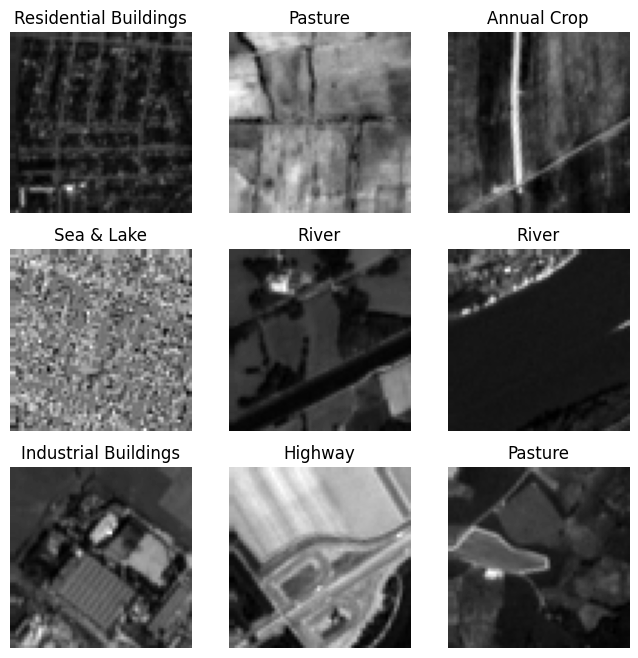

In [ ]:
figure = plt.figure(figsize = (8,8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  data = training_data[sample_idx]
  img, label = data['image'], data['label'].item()
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img[3], cmap = "gray")
plt.show()

# Visualizing dataset in FCC

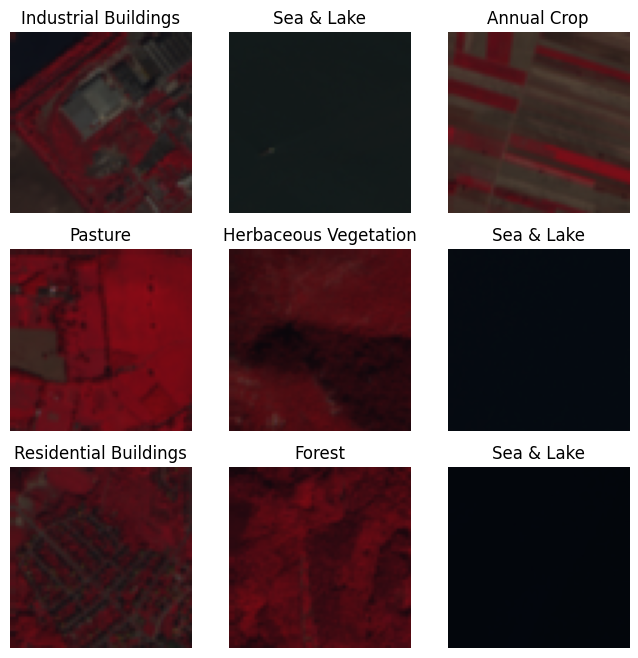

In [ ]:
figure = plt.figure(figsize = (8,8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  data = training_data[sample_idx]
  img, label = data['image'], data['label'].item()
  img = torch.stack((img[7], img[3], img[2]), dim=0)
  img = torch.permute(img, (1,2,0))
  #img = T.ToPILImage()(img)

  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  #print(img)
  plt.imshow(img/10000.)
plt.show()

In [ ]:
batch_size = 4

#create data loaders
train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle=True)

for data in test_dataloader:
  X = data['image']
  y = data['label']
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([4, 13, 64, 64])
Shape of y: torch.Size([4]) torch.int64


## Creating Models

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(13*64*64,512),
        nn.ReLU(),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32,10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits


In [ ]:
model = NeuralNetwork().to(device)

In [ ]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=53248, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, img_data in enumerate(dataloader):
    X = img_data['image']
    y = img_data['label']

    X, y = X.to(device), y.to(device)

    #Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch%4 == 0:
      loss, current = loss.item(), (batch+1)*len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")



In [ ]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for img_data in dataloader:
      X = img_data['image']
      y = img_data['label']

      X, y  = X.to(device), y.to(device)
      pred = model(X)
      test_loss += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}% , Avg loss: {test_loss:>8f} \n")


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.247814 [    4/   60]
loss: 2.269477 [   20/   60]
loss: 2.285388 [   36/   60]
loss: 2.238809 [   52/   60]
Test Error: 
 Accuracy: 0.0% , Avg loss: 0.400000 

Epoch 2
-------------------------------
loss: 6.009766 [    4/   60]
loss: 2.316122 [   20/   60]
loss: 2.070102 [   36/   60]
loss: 2.336273 [   52/   60]
Test Error: 
 Accuracy: 0.0% , Avg loss: 0.400000 

Epoch 3
-------------------------------
loss: 2.055172 [    4/   60]
loss: 2.351707 [   20/   60]
loss: 2.348801 [   36/   60]
loss: 2.191701 [   52/   60]
Test Error: 
 Accuracy: 0.0% , Avg loss: 0.400000 

Epoch 4
-------------------------------
loss: 2.346558 [    4/   60]
loss: 2.349532 [   20/   60]
loss: 2.330189 [   36/   60]
loss: 2.318291 [   52/   60]
Test Error: 
 Accuracy: 0.0% , Avg loss: 0.400000 

Epoch 5
-------------------------------
loss: 2.335517 [    4/   60]
loss: 2.203433 [   20/   60]
loss: 2.348411 [   36/   60]
loss: 2.275111 [   52/   60]
Test Error: 

## Making Predictions with Model

In [ ]:
sample_idx = torch.randint(int(len(test_data)), size=(1,)).item()
model.eval()
x = test_data[sample_idx]['image']
y = test_data[sample_idx]['label']

with torch.no_grad():
  x = x.unsqueeze(0)
  x = x.to(device)
  pred = model(x)
  predicted, actual = labels_map[pred[0].argmax(0).item()], labels_map[y.item()]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Permanent Crop", Actual: "Permanent Crop"


Text(0.5, 0, 'Residential Buildings')

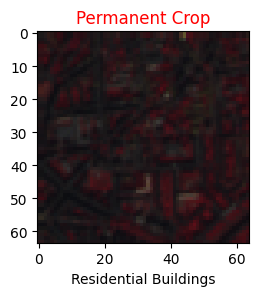

In [ ]:
sample_idx = torch.randint(len(test_data), size=(1,)).item()
model.eval()
x = test_data[sample_idx]['image']
y = test_data[sample_idx]['label']
with torch.no_grad():
  x = x.unsqueeze(0)
  x = x.to(device)
  pred = model(x)
  predicted = pred[0].argmax(0).cpu().item()
  if predicted == y:
    color = 'green'
  else:
    color = 'red'

plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.grid(False)
plt.axis()
test_img = torch.stack((x[0][7], x[0][3], x[0][2]), dim=0)
test_img = torch.permute(test_img, (1,2,0))
plt.imshow(test_img.cpu()/10000, cmap='gray')
plt.title(labels_map[predicted], color=color)
plt.title(labels_map[predicted], color=color)
plt.xlabel(labels_map[y.item()])


# Convolutional Neural Network

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(13, 6, 5)
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.conv3 = nn.Conv2d(16, 120, 5)
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(120*9*9, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.pool(nn.functional.relu(self.conv1(x)))
    x = self.pool(nn.functional.relu(self.conv2(x)))
    x = nn.functional.relu(self.conv3(x))
    x = self.flat(x)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]          # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

net = LeNet()


In [ ]:
net = net.to(device)
print(net)

LeNet(
  (conv1): Conv2d(13, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9720, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.282074 [    4/   60]
loss: 2.270337 [   20/   60]
loss: 2.250924 [   36/   60]
loss: 2.251172 [   52/   60]
Test Error: 
 Accuracy: 0.0% , Avg loss: 0.400000 

Epoch 2
-------------------------------
loss: 2.295302 [    4/   60]
loss: 2.343102 [   20/   60]
loss: 2.288848 [   36/   60]
loss: 2.188936 [   52/   60]
Test Error: 
 Accuracy: 0.0% , Avg loss: 0.400000 

Epoch 3
-------------------------------
loss: 2.329052 [    4/   60]
loss: 2.207388 [   20/   60]
loss: 2.348496 [   36/   60]
loss: 2.297423 [   52/   60]
Test Error: 
 Accuracy: 0.0% , Avg loss: 0.400000 

Epoch 4
-------------------------------
loss: 2.348491 [    4/   60]
loss: 2.273808 [   20/   60]
loss: 2.350722 [   36/   60]
loss: 2.359535 [   52/   60]
Test Error: 
 Accuracy: 0.0% , Avg loss: 0.400000 

Epoch 5
-------------------------------
loss: 2.297392 [    4/   60]
loss: 2.389553 [   20/   60]
loss: 2.344977 [   36/   60]
loss: 2.335275 [   52/   60]
Test Error: 

Text(0.5, 0, 'Highway')

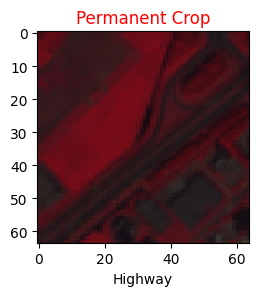

In [ ]:
sample_idx = torch.randint(len(test_data), size=(1,)).item()
model.eval()
x = test_data[sample_idx]['image']
y = test_data[sample_idx]['label']
with torch.no_grad():
  x = x.unsqueeze(0)
  x = x.to(device)
  pred = model(x)
  predicted = pred[0].argmax(0).cpu().item()
  if predicted == y:
    color = 'green'
  else:
    color = 'red'

plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.grid(False)
plt.axis()
test_img = torch.stack((x[0][7], x[0][3], x[0][2]), dim=0)
test_img = torch.permute(test_img, (1,2,0))
plt.imshow(test_img.cpu()/10000, cmap='gray')
plt.title(labels_map[predicted], color=color)
plt.title(labels_map[predicted], color=color)
plt.xlabel(labels_map[y.item()])
